## 1. Imports and configuration

In [10]:
# Imports
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.graph_objects as go
from kaggle_datasets import KaggleDatasets

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Dense
import tensorflow_addons as tfa

sns.set()

### 1.1 TPU configuration

We are going to use [TPUs](https://en.wikipedia.org/wiki/Tensor_Processing_Unit) hardware, as they can dramatically speed up deep learning processes and are thus well-suited for our task. As stated in [this tutorial notebook](https://www.tensorflow.org/guide/tpu), "TPUs are typically Cloud TPU workers, which are different from the local process running the user's Python program. Thus, you need to do some initialization work to connect to the remote cluster and initialize the TPUs." :

In [3]:
try:
    # TPU detection
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print("Running on TPU ", tpu.cluster_spec().as_dict()["worker"])
    # Connection to TPU
    tf.config.experimental_connect_to_cluster(tpu)
    # Initialization of the TPU devices
    tf.tpu.experimental.initialize_tpu_system(tpu)
    # Create a state & distribution policy on the TPU devices
    strategy = tf.distribute.experimental.TPUStrategy(tpu)

except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    strategy = tf.distribute.MirroredStrategy()

Running on TPU  ['10.0.0.2:8470']


According to the [Kaggle TPU documentation](https://www.kaggle.com/docs/tpu), a rule of thumb is to use a batch size of 128 elements per core to take full advantage of the TPU capacities :

In [39]:
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

print("Number of replicas : ", strategy.num_replicas_in_sync)
print("Batch size : ", BATCH_SIZE)

Number of replicas :  8
Batch size :  128


## 2. Data import and exploration

Two sets of data need to be accessed to :
- The labels are recorded in a csv file that can be handled in the usual manner with Pandas ;
- The images will be collected from their Google Cloud Storage (GCS) bucket to take advantage of the TPUs. 

We are also going to do some data exploration in order to better understand them and the task at hand. 

### 2.1 Labels and images import

In [11]:
# Labels import as a DataFrame
train_label_csv = "../input/plant-pathology-2021-fgvc8/train.csv"
train_label_df = pd.read_csv(train_label_csv)

As explained in [his part of the TensorFlow tutorial](https://www.tensorflow.org/guide/tpu#load_the_dataset), the TPUs need to be fed with data quickly enough. This is why we cannot use the local file system as usual. We will get the data from their GCS bucket so we can use the `tf.data.Dataset` API to input the images in our Neural Network. Here we just specify the images paths :

In [6]:
# Get GCS bucket path
gcs_ds_path = KaggleDatasets().get_gcs_path("plant-pathology-2021-fgvc8")

# Get the images paths
train_images_path = gcs_ds_path + "/train_images/"
files_ls = tf.io.gfile.glob(train_images_path + '*.jpg')

### 2.2 Data exploration

#### 2.2.1 Labels exploration and encoding

We are going to get a general overview of the labels distribution, while encoding them in an appropriate manner :

In [3]:
print("Number of examples in the train set : {}".format(len(train_label_df)))

Number of examples in the train set : 18632


In [4]:
train_label_df.head()

image                           labels
0  800113bb65efe69e.jpg                          healthy
1  8002cb321f8bfcdf.jpg  scab frog_eye_leaf_spot complex
2  80070f7fb5e2ccaa.jpg                             scab
3  80077517781fb94f.jpg                             scab
4  800cbf0ff87721f8.jpg                          complex

We can see on the second row that an image can be associated with several labels (separated by a space in the csv), hence our task will be multi-label classification. To handle this, we are next going to one-hot-encode these labels :

In [12]:
# Labels one-hot-encoding
mlb = MultiLabelBinarizer()

train_label_df["labels_list"] = train_label_df.labels.apply(
    lambda x: x.split(' '))

df_class_dummies = pd.DataFrame(mlb.fit_transform(
    train_label_df.labels_list), columns=mlb.classes_, index=train_label_df.index)
train_label_df = pd.concat(
    [train_label_df[["image", "labels"]], df_class_dummies], axis=1)

# One-hot-encoded labels
pathologies = mlb.classes_
labels = train_label_df[pathologies]

train_label_df.head()

image                           labels  complex  \
0  800113bb65efe69e.jpg                          healthy        0   
1  8002cb321f8bfcdf.jpg  scab frog_eye_leaf_spot complex        1   
2  80070f7fb5e2ccaa.jpg                             scab        0   
3  80077517781fb94f.jpg                             scab        0   
4  800cbf0ff87721f8.jpg                          complex        1   

   frog_eye_leaf_spot  healthy  powdery_mildew  rust  scab  
0                   0        1               0     0     0  
1                   1        0               0     0     1  
2                   0        0               0     0     1  
3                   0        0               0     0     1  
4                   0        0               0     0     0

Next we can visualize the label distribution :

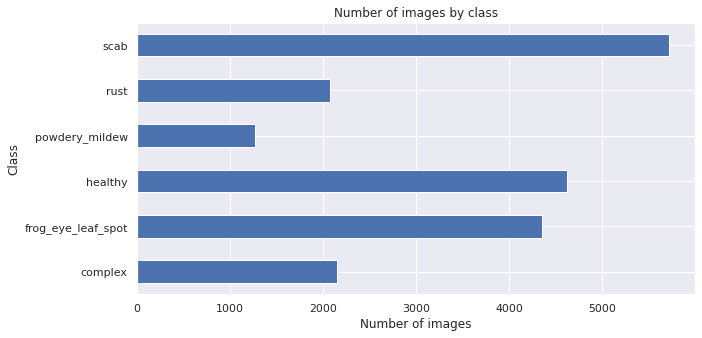

In [6]:
plt.figure(figsize=(10, 5))
train_label_df[pathologies].sum().plot.barh()
plt.title("Number of images by class")
plt.xlabel("Number of images")
plt.ylabel("Class")
plt.show()

We can see that the labels are unbalanced, rust and powdery mildew affected leaves are much less numerous than scab or frog eye leaf spot affected ones. We have a fair amount of healthy leaves and a few complex cases.  
Next we can check how many multi-label cases we have :

In [7]:
multi_label_count = train_label_df[pathologies].sum(axis=1).value_counts()

for index, value in multi_label_count.items():
    print("{} labels : {} images".format(index, value))

1 labels : 17277 images
2 labels : 1155 images
3 labels : 200 images


Finally, we can plot an interactive parallel categories diagram to better understand the multi-label cases distribution. The complex cases are highlighted in green :

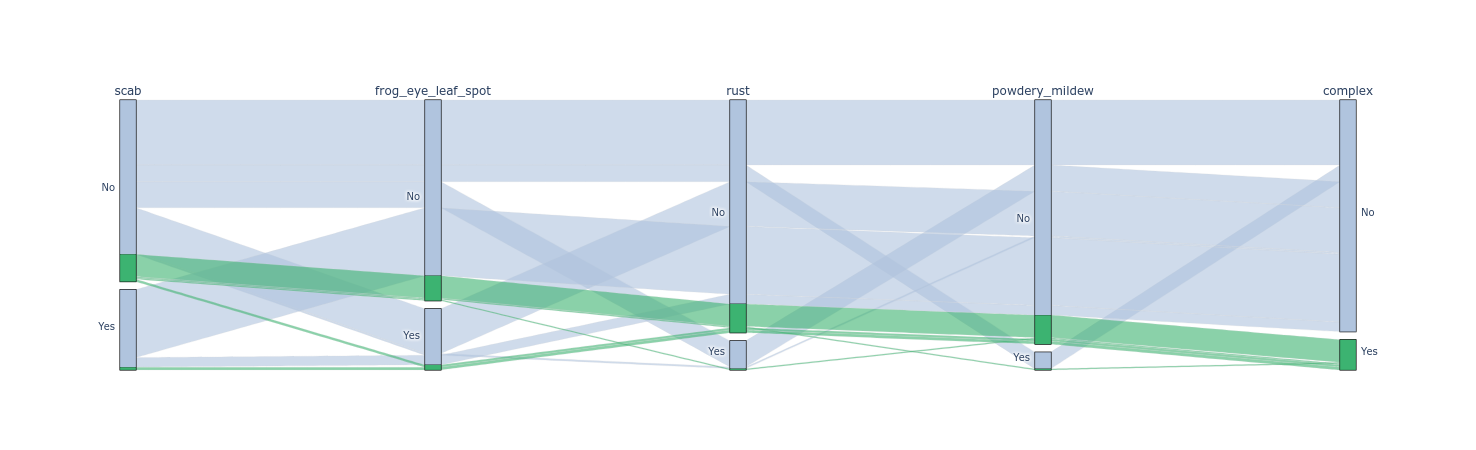

In [13]:
# Create dimensions
dimensions = []

for pathology in ["scab", "frog_eye_leaf_spot", "rust", "powdery_mildew", "complex"]:
    dim = go.parcats.Dimension(
        values=train_label_df[pathology],
        categoryarray=[0, 1],
        ticktext=['No', 'Yes'],
        label=pathology)
    dimensions.append(dim)

# Create parcats trace
color = train_label_df.complex
colorscale = [[0, 'lightsteelblue'], [1, 'mediumseagreen']]

fig = go.Figure(data=[go.Parcats(dimensions=dimensions,
                                 line={'color': color,
                                       'colorscale': colorscale},
                                 arrangement='freeform')])

fig.show()

#### 2.2.2 Images exploration

Just to get a sense of the image resolution diversity of the dataset, we can get check those of the first 100 images (collecting the image resolution of the whole dataset would take much longer) :

In [13]:
img_sizes = set()

for file in files_ls[:100]:
    img_file = tf.io.read_file(file)
    img = tf.image.decode_jpeg(img_file, channels=3)
    img_size = tuple(img.shape[:2].as_list())
    img_sizes.add(img_size)

print("Some image sizes found : ", img_sizes)

Some image sizes found :  {(3000, 4000), (2672, 4000), (3456, 4608), (1728, 2592)}


We can see that the images have different resolutions. However, these resolutions seem relatively high compared to the typical CNN input size (for comparison, the resolution required for Keras EfficientNetB7 implementation is 600 x 600 px), the images will need to be resized at a constant resolution to be fed in our model.  
Next, we can plot a few examples of each pathology to get a sense of their visual characteristics :

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



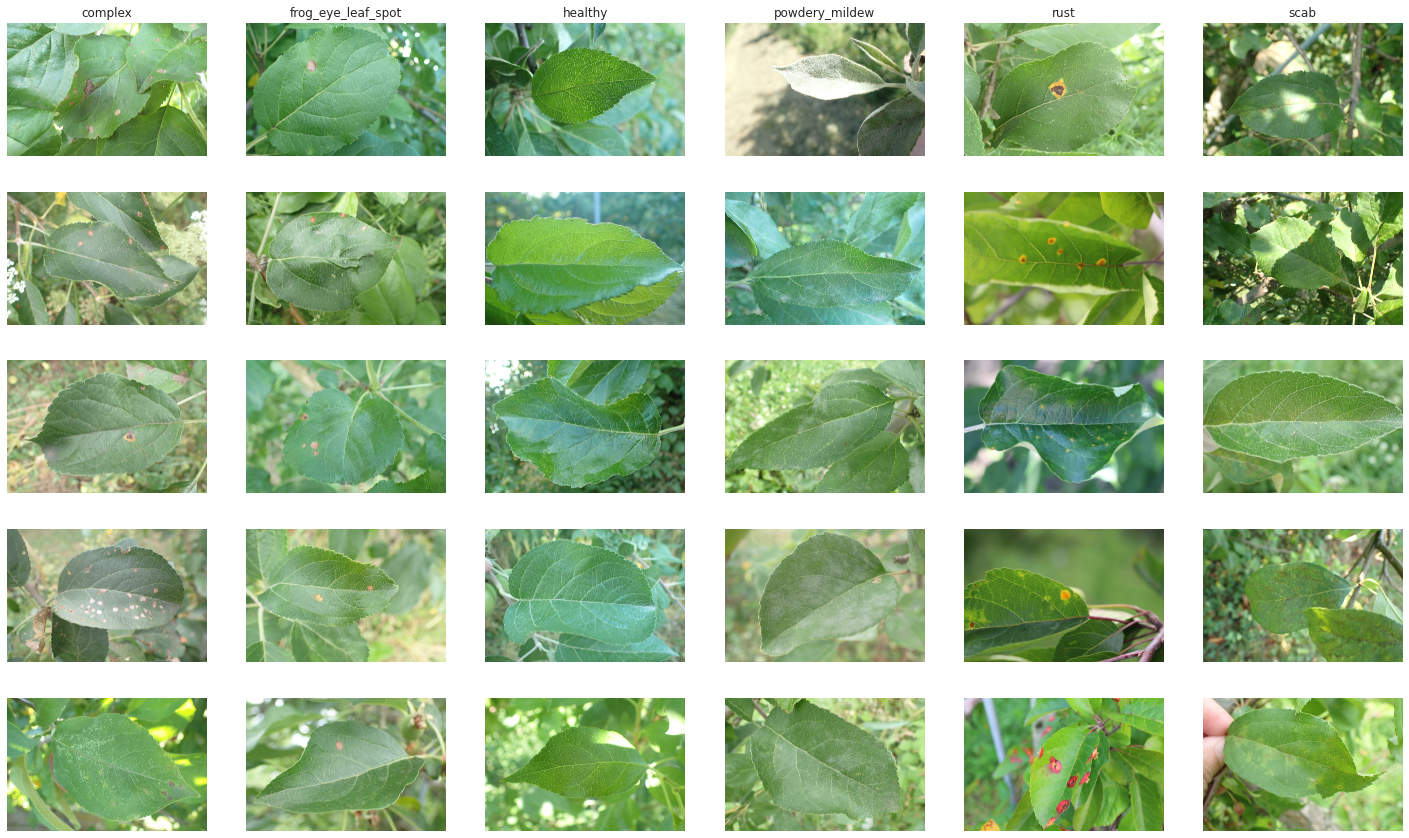

In [14]:
n_examples = 5

fig, ax = plt.subplots(n_examples, len(mlb.classes_),
                       figsize=(25, 3 * n_examples))

for j, pathology in enumerate(pathologies):
    shuffled_df = train_label_df.sample(frac=1)
    examples = shuffled_df[train_label_df.labels ==
                           pathology].iloc[:n_examples]
    i = 0
    for index, example in examples.iterrows():
        img_name = example.image
        img_path = train_images_path + img_name
        img_file = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img_file, channels=3)
        img_size = img.shape[:2].as_list()
        ax[i, j].imshow(img)
        ax[i, j].axis('off')
        if i == 0:
            ax[i, j].set_title(pathology)
        i += 1

plt.show()

## 3. Data augmentation and dataset generation

The next step will be to create tensorflow [datasets](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) from our data, for the training and validation sets. Datasets allow to work efficiently with TPUs by feeding them with data fast enough.  
Our input pipeline will :
1. Read and decode images ;
2. Crop them to their central square and resize them;
3. Apply image augmentation to the training set, the output being 400 x 400 px images ;

A key step of the pipeline is also to cache the dataset in memory at first iteration with the `dataset.cache()` method. This way the training of our model will be way faster from the second iteration. This need to be applied before data augmentation, as we want to get different data augmentation at each epoch during the training.

I tried various options for image augmentation but what seemed to work best was to not alter the original images too much, thus applying only subtle changes. We will apply changes to brightness, contrast and saturation. The images will also be flipped along their horizontal and vertical axis, and a small random crop (from 426 x 426 px to 400 x 400 px) will also be applied.

In [15]:
IMG_HEIGHT_RESIZE = 426
IMG_WIDTH_RESIZE = 426
IMG_HEIGHT = 400
IMG_WIDTH = 400

# Autotuned data prefetching
AUTO = tf.data.experimental.AUTOTUNE


def crop_center(image):
    """
    Crop an image to its central square
    """
    h, w = tf.shape(image)[-3], tf.shape(image)[-2]
    if h > w:
        cropped_image = tf.image.crop_to_bounding_box(
            image, (h - w) // 2, 0, w, w)
    else:
        cropped_image = tf.image.crop_to_bounding_box(
            image, 0, (w - h) // 2, h, h)
    return cropped_image


def data_augment(image, label):
    """
    Apply data augmentation to images
    """
    image = tf.image.random_brightness(image, 0.3)
    image = tf.image.random_contrast(image, 1, 3)
    image = tf.image.random_saturation(image, lower=1, upper=1.3)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_crop(image, [IMG_HEIGHT, IMG_WIDTH, 3])
    return image, label


def process_img(filepath, label):
    """
    Read an image from its filepath, crop it to its central square and resize it
    """
    image = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = crop_center(image)
    image = tf.image.resize(image, [IMG_HEIGHT_RESIZE, IMG_WIDTH_RESIZE])

    return image, label


def get_training_dataset(filenames, labels, do_aug=True):
    """
    Create the training dataset
    """
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(process_img, num_parallel_calls=AUTO)
    dataset = dataset.cache()  # Cache the dataset in memory at first iteration
    if do_aug:
        dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.repeat()
    dataset = dataset.prefetch(AUTO)
    return dataset


def resize_validation_dataset(image, label):
    """
    Resize the validation dataset images to the same dimensions as the training dataset
    """
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    return image, label


def get_validation_dataset(filenames, labels):
    """
    Create the validation dataset
    """
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(process_img, num_parallel_calls=AUTO)
    dataset = dataset.map(resize_validation_dataset, num_parallel_calls=AUTO)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()  # Cache the dataset in memory at first iteration
    dataset = dataset.prefetch(AUTO)
    return dataset

To check the results of our image augmentation process, we can visualize a single image augmented several times :

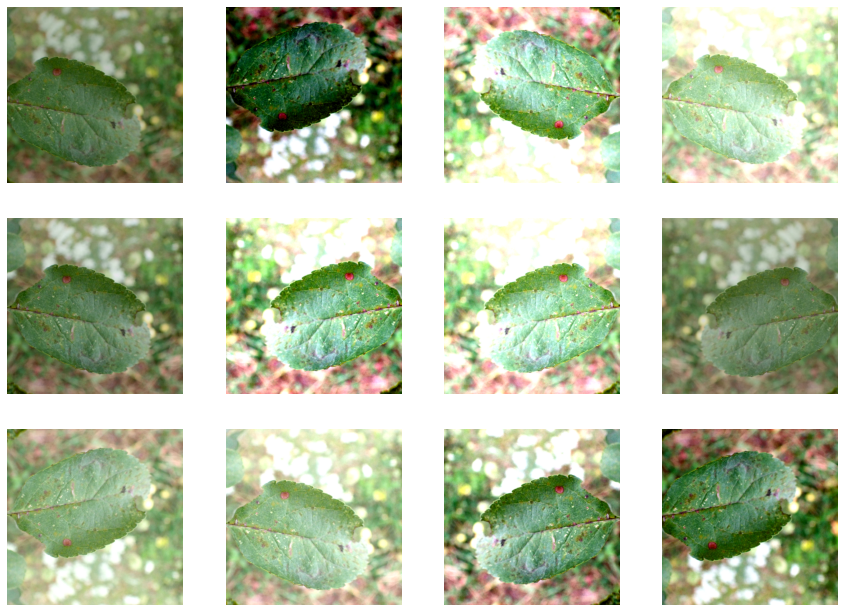

In [16]:
row = 3
col = 4

all_elements = get_training_dataset(files_ls, labels, do_aug=False).unbatch()
one_element = tf.data.Dataset.from_tensors(next(iter(all_elements)))
augmented_element = one_element.repeat().map(data_augment).batch(row * col)

for (img, label) in augmented_element:
    plt.figure(figsize=(15, int(15 * row / col)))
    for j in range(row * col):
        plt.subplot(row, col, j+1)
        plt.axis('off')
        plt.imshow(img[j, ])
    plt.show()
    break

We can now split the data by generating a training and a validation dataset :

In [17]:
train_files, val_files, train_labels, val_labels = train_test_split(
    files_ls, labels, test_size=0.1, random_state=123)

ds_train = get_training_dataset(train_files, train_labels)
ds_val = get_validation_dataset(val_files, val_labels)

## 4. Training of the CNN model

Now we will move to the training process of our model. My final solution for this challenge was to average the outputs of 3 models : 
- a ResNet50, 
- an EfficientNet, 
- and a [Vision Transformer](https://ai.googleblog.com/2020/12/transformers-for-image-recognition-at.html) model (thanks to [this](https://github.com/faustomorales/vit-keras) helpful implementation).

However, the training processes for these 3 models are relatively similar so for the purpose of this article I will only present the ResNet50 training. The main subtle changes between the different model training are different image sizes as input, and different base model weights. The code to train the other 2 models is available in my corresponding [GITHUB REPOSITORY](github_repository_address). 

So here we are going to use the ResNet50 architecture with the imagenet weights as a starting point, but all the layers will be retrainable. As we need to train our model on 6 different labels, the output layer will be a dense layer with 6 outputs form sigmoid activations. 

In [18]:
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH) + (3,)

with strategy.scope():
    base_model = ResNet50(
        include_top=False, input_shape=IMG_SHAPE, weights='imagenet')

94773248/94765736 [==============================] - 1s 0us/step


In [19]:
n_labels = len(pathologies)

base_model.trainable = True

with strategy.scope():
    inputs = tf.keras.Input(shape=IMG_SHAPE)
    x = base_model(inputs, training=True)
    x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)

    outputs = Dense(n_labels, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 400, 400, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 13, 13, 2048)      23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 12294     
Total params: 23,600,006
Trainable params: 23,546,886
Non-trainable params: 53,120
_________________________________________________________________


The performance metric evaluated was the F1-score. To better align our loss function with the evaluation metric, it would be nice to directly optimize for the F1-score, but it is not differentiable. To overcome this, as explained in this [interesting article](https://towardsdatascience.com/the-unknown-benefits-of-using-a-soft-f1-loss-in-classification-systems-753902c0105d), we can create a custom loss where we modify the F1-score such as we replace the counts of true positives, false positives and false negatives by the sums of their likelihood values, by replacing each $y$ of the regular F1-score formula (defined in $\{0, 1\}$) by their probabilities (defined in $[0, 1]$) : 

In [20]:
# from https://towardsdatascience.com/the-unknown-benefits-of-using-a-soft-f1-loss-in-classification-systems-753902c0105d
def macro_soft_f1(y, y_hat):
    """
    Compute the macro soft F1-score as a cost.
    Average (1 - soft-F1) across all labels.
    Use probability values instead of binary predictions.

    Args:
        y (int32 Tensor): targets array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix of shape (BATCH_SIZE, N_LABELS)

    Returns:
        cost (scalar Tensor): value of the cost function for the batch
    """

    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    soft_f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    cost = 1 - soft_f1  # reduce 1 - soft-f1 in order to increase soft-f1
    macro_cost = tf.reduce_mean(cost)  # average on all labels

    return macro_cost

We will use the Adam gradient descent optimizer, with a learning rate starting at 0.0005 :

In [21]:
base_learning_rate = 0.00005

with strategy.scope():
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
                  loss=macro_soft_f1,
                  metrics=[tfa.metrics.F1Score(num_classes=n_labels, average="macro", threshold=0.5, name="f1_score")])

We will use 2 callback functions to adapt the learning rate and the stopping iteration. The learning rate will be divided by 5 when de validation loss is plateauing, and we will stop the training if we can't improve it after 3 iterations.

In [22]:
epochs = 30

rlp = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', patience=1, verbose=1, factor=0.2)
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

history = model.fit(ds_train,
                    validation_data=ds_val,
                    epochs=epochs,
                    callbacks=[rlp, es],
                    steps_per_epoch=len(train_files)//BATCH_SIZE,
                    validation_steps=len(val_files)//BATCH_SIZE)

Epoch 1/30
131/131 [==============================] - 938s 6s/step - loss: 0.5213 - f1_score: 0.5279 - val_loss: 0.2577 - val_f1_score: 0.8364
Epoch 2/30
131/131 [==============================] - 46s 350ms/step - loss: 0.2656 - f1_score: 0.8243 - val_loss: 0.2493 - val_f1_score: 0.8309
Epoch 3/30
131/131 [==============================] - 45s 345ms/step - loss: 0.2477 - f1_score: 0.8439 - val_loss: 0.2340 - val_f1_score: 0.8534
Epoch 4/30
131/131 [==============================] - 45s 345ms/step - loss: 0.2370 - f1_score: 0.8551 - val_loss: 0.2319 - val_f1_score: 0.8566
Epoch 5/30
131/131 [==============================] - 45s 341ms/step - loss: 0.2300 - f1_score: 0.8607 - val_loss: 0.2264 - val_f1_score: 0.8557
Epoch 6/30
131/131 [==============================] - 45s 347ms/step - loss: 0.2220 - f1_score: 0.8684 - val_loss: 0.2210 - val_f1_score: 0.8641
Epoch 7/30
131/131 [==============================] - 44s 340ms/step - loss: 0.2239 - f1_score: 0.8637 - val_loss: 0.2179 - val_f1_s

We reach a F1-score slightly higher than 0.88 on our validation set.  
As expected, you can notice on the training logs that the first iteration was relatively slow (during 637 s) while the training and validation datasets were being cached, then the epochs got much faster (45 s) for the next iterations thanks to the TPUs.  
Now let's visualize the learning curves :

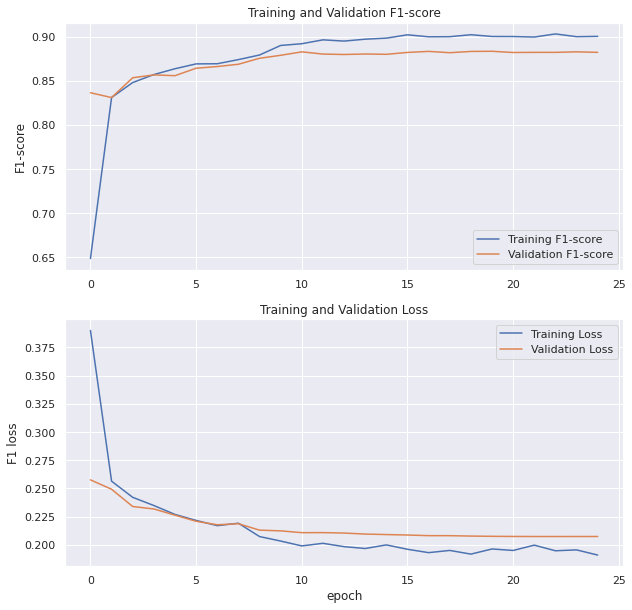

In [23]:
f1_score = history.history['f1_score']
val_f1_score = history.history['val_f1_score']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(f1_score, label='Training F1-score')
plt.plot(val_f1_score, label='Validation F1-score')
plt.legend(loc='lower right')
plt.ylabel('F1-score')
plt.title('Training and Validation F1-score')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('F1 loss')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

We can see that our CNN learned mainly during the first few epochs then marginally improved from epoch 10.

In [24]:
# Model saving
model_name = 'resnet_model.h5'
model.save(model_name)

## 5. Results analysis

Now we can analyze the predictions of our model on the validation set to get a sense of what worked and what could be improved.

In [25]:
# Predictions on the validation dataset
val_predictions = model.predict(ds_val, batch_size=BATCH_SIZE)

A few formatting operations are necessary to get the results in their final shape :
- We need to transform the probabilites associated with each labels to hard True/False values according to choosen thresholds ;
- We need to get back from True/False values to text labels ;
- What to do for images where none of the label probabilities are above the chosen thresholds ? There are multiple ways to handle that. We could let it as is to avoid generating false positives, we could replace it by "healthy" or "complex" by default, or follow other custom rules. From my different tries, what worked best was to select the label corresponding to the maximum probability in these cases.

In [26]:
def format_predictions(preds, files, thresholds, fill_no_label=False, labels=mlb.classes_, oh_labels=True):
    """
    Format predictions to get a DataFrame from the prediction matrix

    Args:
        preds (float32 numpy array): predictions matrix (N_IMAGES, N_LABELS)
        files (list): list of image files
        thresholds (list): list of prediction thresholds associated with each labels 
        fill_no_label (boolean): wether or not to fill empty predictions with argmax
        labels (list): list of labels names
        oh_labels (boolean): wether or not to get booleans associated with labels in the output DataFrame

    Returns:
        predictions_df (DataFrame): predictions DataFrame
    """

    preds_copy = preds.copy()

    # Handling no label cases
    if fill_no_label:
        for i in range(preds_copy.shape[0]):
            if np.all(preds_copy[i, :] < thresholds):
                preds_copy[i, np.argmax(preds_copy[i, :])] = 1

    # Apply thresholds to get boolean values
    for j in range(preds_copy.shape[1]):
        preds_copy[:, j] = np.where(preds_copy[:, j] < thresholds[j], 0, 1)

    # Reverse MultiLabelBinarizer
    mlb_predictions = mlb.inverse_transform(preds_copy)
    mlb_predictions = [' '.join(x) for x in mlb_predictions]

    # Create the output DataFrame
    predictions_series = pd.Series(mlb_predictions, name="labels")
    oh_predictions_df = pd.DataFrame(data=preds_copy, columns=labels)
    file_names = [x.split('/')[-1] for x in files]
    file_names_series = pd.Series(file_names, name="file_name")
    predictions_df = pd.concat([file_names_series, predictions_series], axis=1)

    # Get one-hot-labels in the output DataFrame
    if oh_labels:
        predictions_df = pd.concat([predictions_df, oh_predictions_df], axis=1)

    return predictions_df

In [27]:
val_predictions_df = format_predictions(
    val_predictions, val_files, thresholds=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
val_predictions_df.head()

file_name                           labels  complex  \
0  bb22da4eb9e50703.jpg                             scab      0.0   
1  d3d237e0c3ca3465.jpg               frog_eye_leaf_spot      0.0   
2  9f9fc8097da181d2.jpg                          healthy      0.0   
3  9a18cd59c633c0bf.jpg                             scab      0.0   
4  8d98e55fc60bc954.jpg  complex frog_eye_leaf_spot scab      1.0   

   frog_eye_leaf_spot  healthy  powdery_mildew  rust  scab  
0                 0.0      0.0             0.0   0.0   1.0  
1                 1.0      0.0             0.0   0.0   0.0  
2                 0.0      1.0             0.0   0.0   0.0  
3                 0.0      0.0             0.0   0.0   1.0  
4                 1.0      0.0             0.0   0.0   1.0

In [ ]:
val_predictions_df["labels"].value_counts()

Then we can compare our predictions distribution with the ground truth :

In [52]:
ground_truth_df = format_predictions(val_labels.values, val_files, thresholds=[
                                     0.5, 0.5, 0.5, 0.5, 0.5, 0.5])

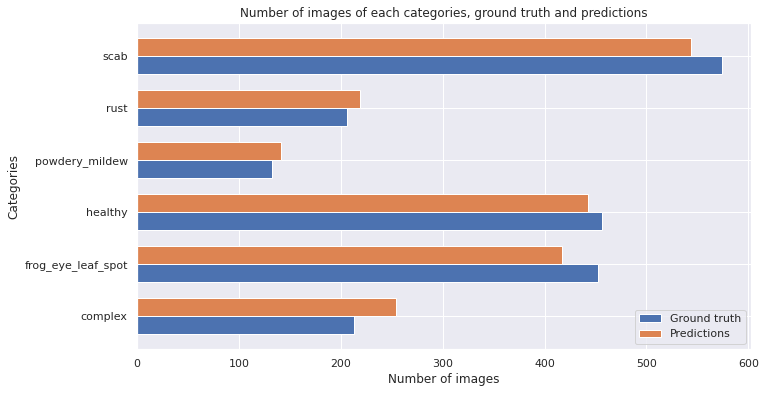

In [53]:
index = np.arange(len(pathologies))
bar_width = 0.35

fig, ax = plt.subplots(figsize=(11, 6))

ax.barh(index, ground_truth_df[pathologies].sum(),
        bar_width, label="Ground truth")
ax.barh(index+bar_width,
        val_predictions_df[pathologies].sum(), bar_width, label="Predictions")

ax.set_xlabel("Number of images")
ax.set_ylabel("Categories")
ax.set_title(
    "Number of images of each categories, ground truth and predictions")
ax.set_yticks(index + bar_width / 2)
ax.set_yticklabels(pathologies)

ax.legend()
plt.show()

We see that we mainly underestimate the number of scab and frog eye leaf spot cases, while overestimating the number of complex cases. The number of healthy, rust and powdery mildew cases are closer to the ground truth.  
To try to better understand the errors, we will compute the rate of images whith at least one mislabeling, and display some example of them :

In [54]:
# Compute a DataFrame of differences between the predictions and the ground truth
diff_ground_truth_pred_df = pd.concat([val_predictions_df["file_name"], ground_truth_df.compare(
    val_predictions_df, keep_shape=True)], axis=1)
diff_ground_truth_pred_df = ground_truth_df.compare(val_predictions_df)
diff_file_names = ground_truth_df.iloc[diff_ground_truth_pred_df.index]["file_name"]
diff_ground_truth_pred_df = diff_ground_truth_pred_df.join(
    diff_file_names).reset_index()

/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:648: UserWarning:

merging between different levels can give an unintended result (2 levels on the left,1 on the right)



In [55]:
# Rate of images with at least one mislabeling
error_rate = len(diff_ground_truth_pred_df) / len(ground_truth_df) * 100
print("Error rate (images with at least one mislabeling) : {:.2f} %".format(
    error_rate))

Error rate (images with at least one mislabeling) : 16.36 %


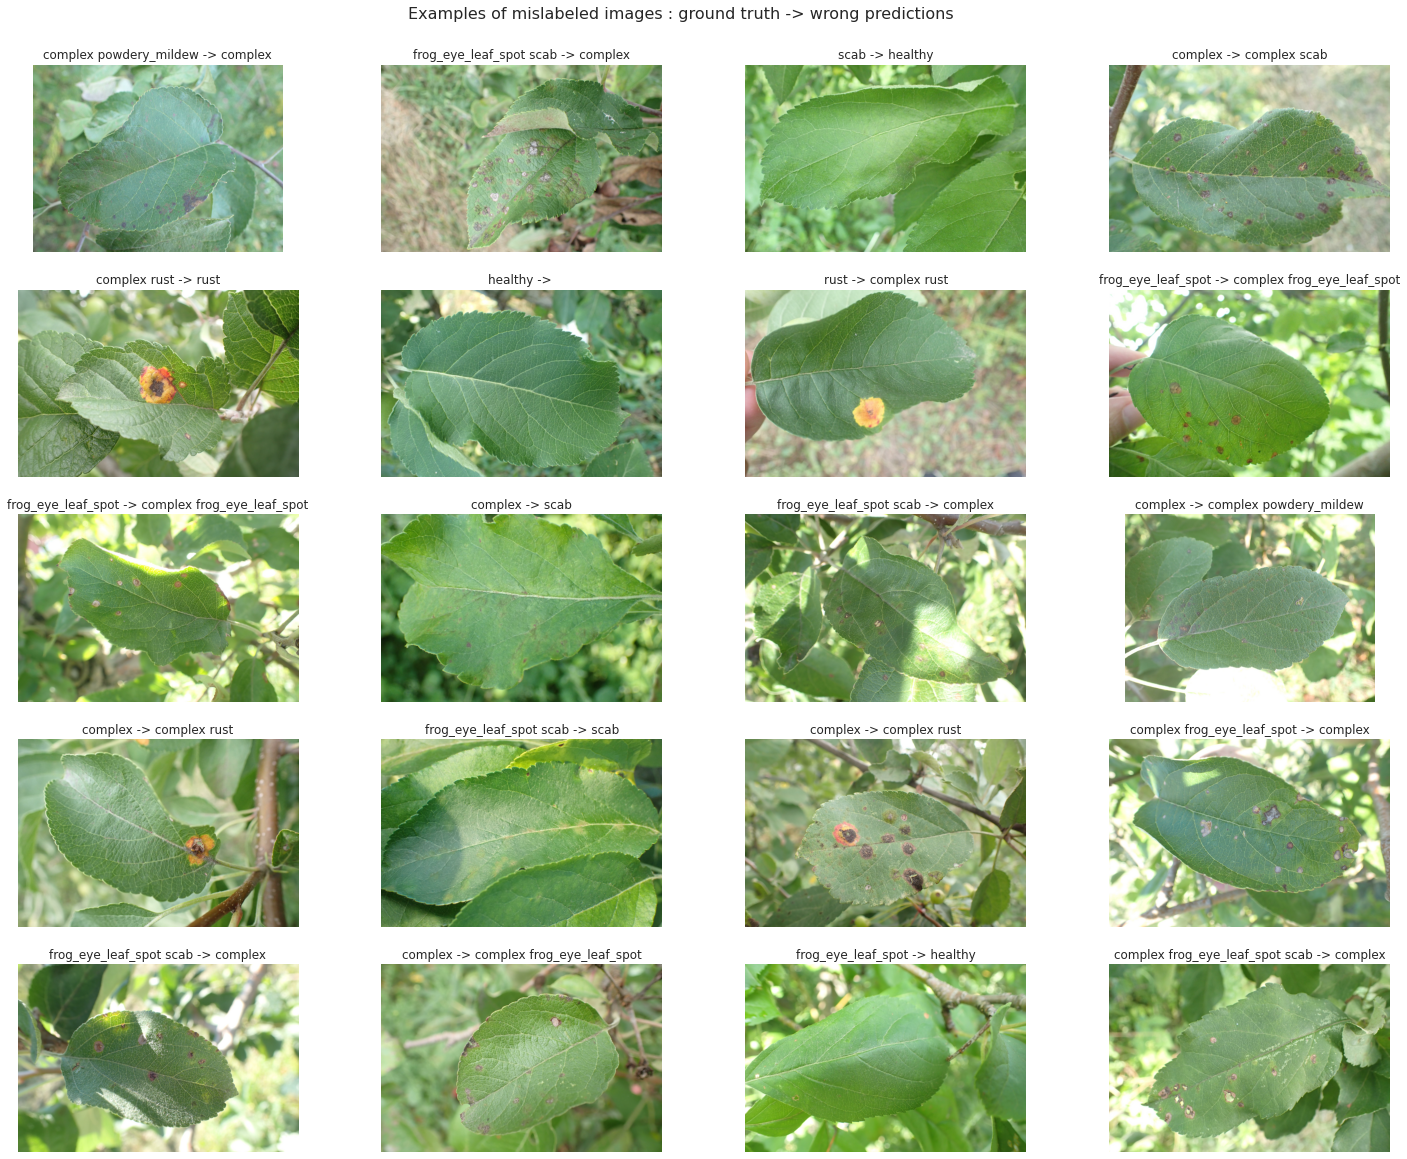

In [83]:
n_examples = 20
diff_examples_df = diff_ground_truth_pred_df.sample(
    frac=1).iloc[:n_examples].reset_index()

fig, ax = plt.subplots(n_examples // 4, 4, figsize=(25, n_examples))
plt_col = 0

for i, row in diff_examples_df.iterrows():
    plt_row = i//4
    img_name = row.file_name
    img_path = train_images_path + img_name
    img_file = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img_file, channels=3)
    ax[plt_row, plt_col].imshow(img)
    ax[plt_row, plt_col].axis('off')
    ax[plt_row, plt_col].set_title(
        row[('labels', 'self')] + ' -> ' + row[('labels', 'other')])
    if plt_col == 3:
        plt_col = 0
    else:
        plt_col += 1

fig.suptitle(
    "Examples of mislabeled images : ground truth -> wrong predictions", fontsize=16, y=0.92)
plt.show()

We can see that our model struggle with the complex cases. But as the Kaggle data description specify it, this label might be noisy : 
> "Unhealthy leaves with too many diseases to classify visually will have the complex class".

From these images it is unclear what visual clues are not well captured by our CNN, but most of the errors seem to be fairly difficult cases.